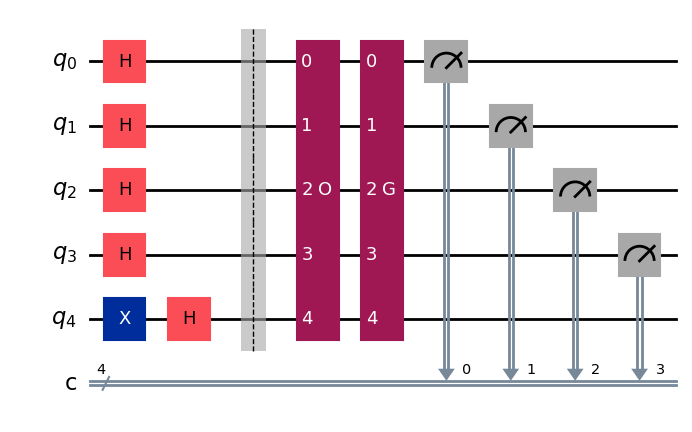

In [70]:
from qiskit import *
import numpy as np
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer.noise import NoiseModel


def oracle_operator(s):
                
    n = len(s)
    
    qc = QuantumCircuit(n+1)
    
    for i, bit in enumerate(s):
        if bit == '0':
            qc.x(i)
    
    qc.mcx(list(range(n)), n)

    for i, bit in enumerate(s):
        if bit == '0':
            qc.x(i)
            
    
    operator = qc.to_gate()
    operator.name = "O"
    
    return operator
    

def diffusion_operator(s):
    n = len(s)
    
    qc = QuantumCircuit(n+1)
    
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n)
    qc.mcx(list(range(n)), n)
    qc.h(n)
    qc.x(range(n))
    qc.h(range(n))
        
    operator = qc.to_gate()
    operator.name = "G"
    
    return operator
    
    
def grovers(s):
    
    n = len(s)

    #Step 1
    qc = QuantumCircuit(n+1, n)
    
    #Step 2
    qc.x(n)
    qc.h(n)
    
    
    #Step 3
    qc.h(np.arange(0, n, 1))
    qc.barrier()
    
    #Step 4
    N  = int(np.floor(np.pi / 4 * np.sqrt(n)))
    
    #Step 5
    for _ in range(N):
        qc.append(oracle_operator(s), range(n+1))
        qc.append(diffusion_operator(s), range(n+1))
        
    #Step 6
    qc.measure(np.arange(0, n, 1),np.arange(0, n, 1))
    
    return qc

    
qc = grovers("1001")
qc.draw('mpl')

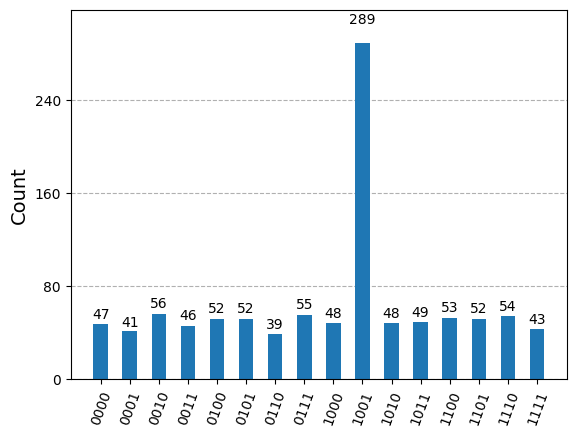

In [72]:
backend = FakeBrisbane()
pm = generate_preset_pass_manager(optimization_level=1)
transpiled_qc = pm.run(qc)
statevectorSampler = StatevectorSampler()
job = statevectorSampler.run([transpiled_qc])
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()
plot_histogram(counts)

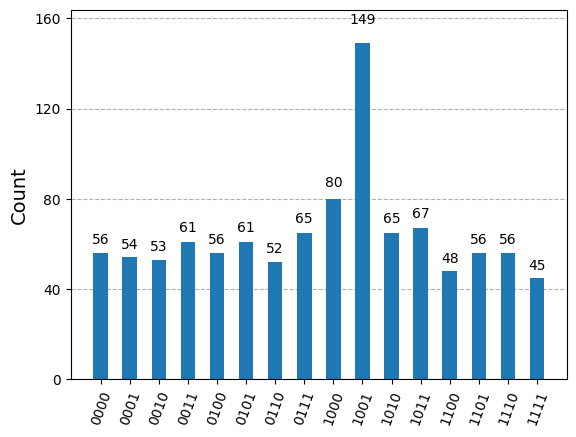

In [73]:
backend = FakeBrisbane()
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
transpiled_qc = pm.run(qc)
sampler = SamplerV2(backend)
job = sampler.run([transpiled_qc])
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()
plot_histogram(counts)

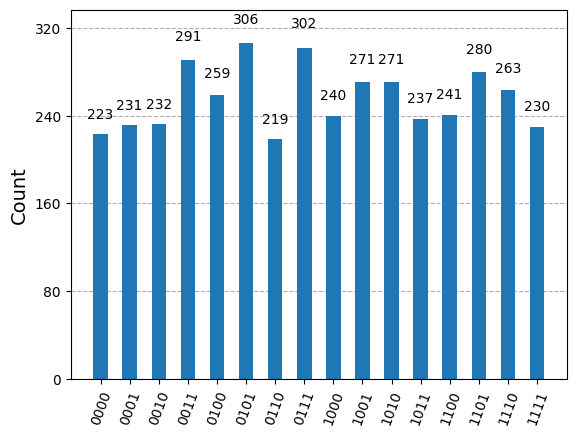

In [77]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    token='65fbbc762db2b521cae43bdee8693166bdaeaade3426a23c3cb1cbcd4eec822717215aea9384c6ded4c0520db0cd739a552d1e99faa0e7c7ee1a88dce5e23736'
)

backend = service.least_busy(operational=True, simulator=False) 
pm = generate_preset_pass_manager(backend=backend, optimization_level=3) 

transpiled_qc = pm.run(qc) 

sampler = SamplerV2(backend)
shots=1024
job = sampler.run([transpiled_qc])
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()
plot_histogram(counts)